In [68]:
import kaggle
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

In [69]:
def feature_engineer(df):
    titles = []
    for name in df['Name']:
        title = name.split(',')[-1].split('.')[0]
        titles.append(title[1:])
    df['Name'] = titles
    df.rename(columns = {'Name':'Title'}, inplace = True)

    decks = []
    for cabin in df['Cabin']:
        if pd.notna(cabin): decks.append(cabin[0])
        else: decks.append(cabin)
    df['Cabin'] = decks
    df.rename(columns = {'Cabin':'Deck'}, inplace = True)
    
    ticket_types = []
    for ticket in df['Ticket']:
        if pd.notna(ticket): 
            ticket_split = ticket.split(' ')
            if len(ticket_split) > 1:
                ticket_types.append(ticket_split[0])
            else: ticket_types.append('basic')
        else: ticket_types.append(ticket)
    df['Ticket'] = ticket_types
    df.rename(columns = {'Ticket':'TicketType'}, inplace = True)
    
    age_estimated = []
    for i in range(len(df)):
        if df['Age'].values[i] != df['Age'].values[i]:
            age_estimated.append(0)
        elif df['Age'].values[i] != int(df['Age'].values[i]) and df['Age'].values[i] > 1:
            age_estimated.append(1)
        else: 
            age_estimated.append(0)
    df['AgeEstimated'] = age_estimated
    
    fam_size  = []
    for i in range(len(df)):
        fam_size.append(df['SibSp'][i]+df['Parch'][i])
    df['FamSize'] = fam_size

    fare_per_person = []
    for i in range(len(df)):
        fare_per_person.append(df['Fare'][i]/(df['FamSize'][i]+1))
    df['FarePerPerson'] = fare_per_person
    
    age_times_class = []
    for i in range(len(df)):
        age_times_class.append(df['Pclass'][i]*df['Age'][i])
    df['AgeClass'] = age_times_class
    
#     famsize_times_sex = []
#     for i in range(len(df)):
#         famsize_times_sex.append(df['FamSize'][i] * 2 if df['Sex'][i] in ['male'] else df['FamSize'][i])
#     df['FamSex'] = famsize_times_sex
    
    return df

In [70]:
def categorify(df, columns):
    rectifier = 1
    for column in columns:
        category_dict = {}
        unique_categories = df[column].unique()
        unknown_index = (unique_categories != unique_categories).nonzero()[0]
        unique_categories = unique_categories.tolist()

        if len(unknown_index): 
            category_indexes = list(range(len(unique_categories)))
            unknown = unique_categories[unknown_index[0]]
            category_indexes[0] = unknown
            unique_categories.pop(unknown_index[0])
            unique_categories.insert(0,unknown)

        else:
            category_indexes = list(range(1,len(unique_categories)+1))

        for i in range(len(unique_categories)):
            category_dict[unique_categories[i]] = category_indexes[i]

        new_column = []
        for i in range(len(df)):
            new_value = category_dict[df[column][i]]
            if new_value == new_value: new_value = int(new_value)
            new_column.append(new_value)

        df[column] = new_column
#         df[column] = new_column.astype('category')
    return df

In [71]:
def fill_missing(df, ignore_columns):
    for column in df.columns:
        if column in ignore_columns: continue
        elif df[column].isna().any():
            median = df[column].describe()['50%']
            nan_indexes = df[column].isna().values
            new_column = np.array(df[column])
            new_column[nan_indexes] = median
#             new_column = new_column.astype('int')
            df[column] = new_column
            df[f'{column}Missing'] = nan_indexes 
    return df

In [72]:
def integerize(df, columns):
    for column in columns:
        df = df.astype({column: 'int'})
    return df

In [73]:
def metric(predictions, targets):
    return 100*(len((predictions == targets).nonzero()[0]) / len(predictions))

In [74]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
    ).sort_values('imp', ascending=False)

In [75]:
path = '/home/francisco/workspace/titanic_kaggle/titanic'

In [76]:
original_train_df = pd.read_csv(f'{path}/train.csv',low_memory=False)
original_test_df = pd.read_csv(f'{path}/test.csv',low_memory=False)

In [77]:
complete_df = pd.concat([original_train_df, original_test_df], ignore_index=True)

In [78]:
complete_df = feature_engineer(complete_df)

In [79]:
complete_df = complete_df.drop(['Fare'], axis=1)

In [80]:
cont = ['Age', 'FarePerPerson']
cat = ['Survived', 'Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'TicketType', 'Deck', 'Embarked', 'AgeEstimated', 'FamSize', 'AgeClassMissing','AgeMissing', 'FarePerPersonMissing','DeckMissing', 'EmbarkedMissing']

In [81]:
complete_df = categorify(complete_df,['Title', 'Sex', 'Deck', 'Embarked', 'TicketType', 'AgeEstimated'])
complete_df = fill_missing(complete_df, ['Survived'])

In [82]:
train_df = complete_df.iloc[:712]
valid_df = complete_df.iloc[712:891].reset_index()
test_df = complete_df.iloc[891:].reset_index()

In [83]:
train_df = integerize(train_df, cat)
valid_df = integerize(valid_df, cat)
test_df = integerize(test_df, cat[1:])

In [198]:
# train_men_df = train_df[train_df['Sex'] == 2].drop(['Sex'], axis=1)
# valid_men_df = valid_df[valid_df['Sex'] == 2].drop(['Sex'], axis=1)
# train_women_df = train_df[train_df['Sex'] == 1].drop(['Sex'], axis=1)
# valid_women_df = valid_df[valid_df['Sex'] == 1].drop(['Sex'], axis=1)

In [88]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
              'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}

model = ensemble.RandomForestClassifier(**parameters)
# rf = ensemble.RandomForestClassifier(n_estimators=10000)

In [89]:
# #Fit man
# rf.fit(train_men_df.values[:,2:],train_men_df.values[:,1])
# preds_rf = rf.predict(valid_men_df.values[:,3:])
# metric(preds_rf.astype('int'), valid_men_df['Survived'].values)

In [90]:
# #Fit women
# rf.fit(train_women_df.values[:,2:],train_women_df.values[:,1])
# preds_rf = rf.predict(valid_women_df.values[:,3:])
# metric(preds_rf.astype('int'), valid_women_df['Survived'].values)

In [91]:
#Fit all data
rf.fit(train_df.values[:,2:],train_df.values[:,1])
preds_rf = rf.predict(valid_df.values[:,3:])
metric(preds_rf.astype('int'), valid_df['Survived'].values)

86.59217877094973

In [123]:
# original_train_df

In [92]:
rf_feat_importance(rf,valid_df.iloc[:,3:])
# rf_feat_importance(rf,train_df.drop(['Survived'], axis=1))

,cols,imp
1,Title,0.272295
2,Sex,0.255016
12,AgeClass,0.100526
11,FarePerPerson,0.092760
0,Pclass,0.074184
10,FamSize,0.050748
3,Age,0.040440
14,DeckMissing,0.034843
4,SibSp,0.027801
7,Deck,0.015006


<AxesSubplot:>

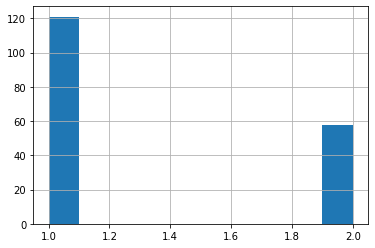

In [77]:
valid_df['Sex'].hist()

/home/francisco/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestC

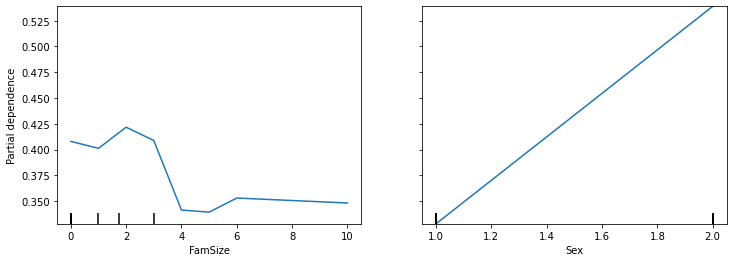

In [79]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf, valid_df.iloc[:,3:], ['FamSize','Sex'],
grid_resolution=20, ax=ax);

In [ ]:
85.47

***

In [148]:
# preds_df = pd.DataFrame()
preds_rf_test = rf.predict(test_df.values[:,3:])
preds_rf_df = pd.DataFrame()

# preds_df['PassengerId'] = test_df['PassengerId'].values
# preds_df['Survived'] = preds_clf.astype('int')
preds_rf_df['PassengerId'] = test_df['PassengerId'].values
preds_rf_df['Survived'] = preds_rf_test.astype('int')

In [150]:
preds_rf_df.to_csv(f'{path}/submission_rf.csv',index=False)

***

In [54]:
preds_train = rf.predict(train_df.values[:,2:])

In [55]:
gt = train_df['Survived'].values

In [56]:
np.count_nonzero(preds_train == gt)/len(gt)

0.9876543209876543